In [248]:
EXP_ID = "v10_h4_thr0p3pct_tol0p3_30dfeat"


In [249]:
import sys
from pathlib import Path

cwd = Path.cwd()
project_root = cwd
while not (project_root / "src").is_dir():
    if project_root.parent == project_root:
        raise RuntimeError("Projektwurzel mit 'src' nicht gefunden.")
    project_root = project_root.parent

print("Erkannte Projektwurzel:", project_root)
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))


Erkannte Projektwurzel: /Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project


In [250]:
import json
from pathlib import Path

# EXP_ID kommt aus der Konfigurationszelle oberhalb
exp_meta_dir = project_root / "data" / "processed" / "experiments"
exp_config_path = exp_meta_dir / f"{EXP_ID}_config.json"

with exp_config_path.open("r", encoding="utf-8") as f:
    exp_config = json.load(f)

print("Geladene Experiment-Konfiguration:", exp_config)


Geladene Experiment-Konfiguration: {'exp_id': 'v10_h4_thr0p3pct_tol0p3_30dfeat', 'label_params': {'horizon_days': 4, 'up_threshold': 0.003, 'down_threshold': -0.003, 'strict_monotonic': False, 'max_adverse_move_pct': 0.003}}


## Allgemeine Beschreibung

Dieses Notebook trainiert ein **Zwei‑Stufen‑Modell mit XGBoost**, das aus News‑ und Kursdaten für EURUSD
zwei Entscheidungen ableitet:

1. **Signal (Stufe 1)**  
   Vorhersage, ob es im betrachteten Horizont eine signifikante Bewegung gibt (`move`)  
   oder ob der Kurs als `neutral` eingestuft wird.  
   → Zielvariable: `signal` (0 = neutral, 1 = Bewegung)

2. **Richtung (Stufe 2)**  
   Falls eine Bewegung vorhergesagt wird, Vorhersage der Bewegungsrichtung: `up` oder `down`.  
   → Zielvariable: `direction` (0 = down, 1 = up, nur für Tage mit `signal == 1`)

Die Label‑Logik (Horizont, Schwellen, Monotonie‑Bedingung) und der konkrete Trainingsdatensatz
werden im Notebook  
`notebooks/1_data_prep_xgboost_two_stage.ipynb`  
über eine **Experiment-ID (`EXP_ID`)** festgelegt. Dieses Notebook verwendet den Datensatz, der dort
für das aktuelle Experiment erzeugt wurde.

Die wichtigsten Bausteine sind:

- vorbereiteter Trainingsdatensatz mit:
  - Kursdaten (z. B. `Close`, `High`, `Low`, `Open`),
  - News‑Tagesfeatures (z. B. `article_count`, `avg_polarity`, `avg_neg`, `avg_neu`, `avg_pos`),
  - abgeleiteten Features (z. B. Candle‑Features, Kalender‑Features, Sentiment‑Anteile),
  - Zielvariablen `label`, `signal`, `direction`.
- ein zeitlicher Split in **Train**, **Validation** und **Test**,
- zwei XGBoost‑Modelle:
  - Stufe 1: binär (`neutral` vs. `move`),
  - Stufe 2: binär (`down` vs. `up`, nur auf Bewegungstagen),
- Auswertung in Form von Accuracy, Precision, Recall, F1 und Konfusionsmatrizen,
- Speicherung der wichtigsten Kennzahlen in einer JSON‑Datei, um verschiedene Experimente
  später vergleichen zu können.


## Experiment-Metadaten (v1_h4_thr0p5pct_strict)

**Allgemein**

- `EXP_ID`: `v2_h4_thr0p5pct_strict`
- Zweck: erste Zwei‑Stufen‑Konfiguration mit 4‑Tage‑Horizont und ±0.5 %‑Schwellen,
  streng monotonem Kursverlauf.
- Data‑Prep‑Notebook: `notebooks/1_data_prep_xgboost_two_stage.ipynb`

**Label-Definition (im Data-Prep angewendet)**

- Datengrundlage: `data/raw/fx/EURUSDX.csv` (Tages‑OHLCV für EURUSD)
- Horizont: `horizon_days = 4` (Tage `t` bis `t+4`)
- Schwellen:
  - `up_threshold = +0.005` (entspricht +0.5 % Lookahead‑Return)
  - `down_threshold = -0.005` (entspricht −0.5 % Lookahead‑Return)
- Pfadbedingung:
  - `strict_monotonic = True`
  - `up`: Kurs steigt an jedem Zwischentag (alle täglichen Differenzen > 0)
  - `down`: Kurs fällt an jedem Zwischentag (alle täglichen Differenzen < 0)
- Label `label`:
  - `up`, `down` oder `neutral` je nach obiger Logik

**Abgeleitete Zielvariablen im Trainingsdatensatz**

- `signal`:
  - `0` = neutral
  - `1` = Bewegung (up oder down)
- `direction`:
  - `0` = down
  - `1` = up
  - `NaN` = neutral (wird im Richtungs‑Modell nicht verwendet)

**Datenquellen und Pfade**

- Label-Dateien:
  - aktuelle Version: `data/processed/fx/eurusd_labels.csv`
  - Experiment-Version: `data/processed/fx/eurusd_labels__v1_h4_thr0p5pct_strict.csv`
- Trainingsdatensätze:
  - aktuelle Version: `data/processed/datasets/eurusd_news_training.csv`
  - Experiment-Version: `data/processed/datasets/eurusd_news_training__v1_h4_thr0p5pct_strict.csv`
- Im Trainings‑Notebook wird aktuell `eurusd_news_training.csv` geladen,
  das aus der Experiment‑Version erzeugt wurde.

**Zeitliche Splits (Train/Val/Test)**

- Test‑Start: `test_start = "2025-01-01"`
  - alle Daten mit `date >= 2025-01-01` → Test‑Split
  - alle Daten davor → Grundlage für Train/Val
- Aufteilung vor Test‑Start:
  - `train_frac_within_pretest = 0.8`
  - 80 % der früheren Daten → Training
  - 20 % der früheren Daten → Validation

**XGBoost-Konfiguration (für beide Stufen)**

_Gemeinsame Einstellungen_

- `objective = "binary:logistic"`
- `eval_metric = "logloss"`
- `max_depth = 3`
- `learning_rate = 0.05`
- `n_estimators = 400`
- `subsample = 0.9`
- `colsample_bytree = 0.9`
- `random_state = 42`
- `early_stopping_rounds = 50`
- Entscheidungsgrenze:
  - Standard‑Threshold `0.5` für die Umwandlung von Wahrscheinlichkeiten → Klasse

_Stufe 1 – Signal-Modell (`signal`: 0 = neutral, 1 = move)_

- Klassenverteilung: stark unausgeglichen (viel mehr `neutral` als `move`)
- `scale_pos_weight`:
  - automatisch gesetzt auf `N_neg / N_pos` des Trainingssplits,
  - sorgt dafür, dass `signal = 1` stärker gewichtet wird.

_Stufe 2 – Richtungs-Modell (`direction`: 0 = down, 1 = up)_

- Datenbasis: nur Zeilen mit `signal == 1` (Bewegungstage)
- `scale_pos_weight = 1.0`
  - aktuell werden `down` und `up` gleich gewichtet.

**Verwendete Features (`FEATURE_COLS`)**

- News‑Features:
  - `article_count` – Anzahl der News pro Tag
  - `avg_polarity` – mittlerer Sentiment‑Score (gesamt)
  - `avg_neg` – mittlerer negativer Sentiment‑Anteil
  - `avg_neu` – mittlerer neutraler Sentiment‑Anteil
  - `avg_pos` – mittlerer positiver Sentiment‑Anteil
  - `pos_share` – `avg_pos / (avg_pos + avg_neg)`
  - `neg_share` – `avg_neg / (avg_pos + avg_neg)`
- Kurs‑ und Kalender‑Features:
  - `intraday_range_pct` – (High − Low) / Close (Tages‑Volatilität)
  - `upper_shadow` – High minus Kerzenkörper (oberer Docht)
  - `lower_shadow` – Kerzenkörper minus Low (untere Lunte)
  - `month` – Monat (1–12)
  - `quarter` – Quartal (1–4)

**Ergebnis-Speicherung**

- JSON-Datei mit allen Metriken:
  - aktueller Pfad (Stand Baseline‑Notebook): `results/two_stage_v0_h4_thr1pct_strict.json`
  - Für dieses Experiment sollte eine eigene Datei verwendet werden, z. B.:
    - `results/two_stage__v1_h4_thr0p5pct_strict.json`
  - Inhalt:
    - Abschnitt `config` mit Label‑ und Datensatz‑Parametern,
    - Abschnitt `signal` (Metriken für Stufe 1),
    - Abschnitt `direction` (Metriken für Stufe 2),
    - Abschnitt `combined_test` (3‑Klassen‑Auswertung `neutral/up/down`).


In [251]:
import sys
from pathlib import Path

# Aktuelles Arbeitsverzeichnis des Kernels ausgeben
cwd = Path.cwd()
print("Aktuelles Arbeitsverzeichnis:", cwd)

# Projektwurzel automatisch finden, indem wir nach oben laufen,
# bis ein Ordner `src` existiert. So funktioniert das Notebook
# unabhängig davon, ob es in `notebooks/` oder einem Unterordner liegt.
project_root = cwd
while not (project_root / "src").is_dir():
    project_root = project_root.parent

print("Erkannte Projektwurzel:", project_root)

# Projektwurzel in den PYTHONPATH aufnehmen, damit `import src....` funktioniert.
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

Aktuelles Arbeitsverzeichnis: /Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project/notebooks
Erkannte Projektwurzel: /Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project


## 1. Setup und Datensatz laden

In diesem Abschnitt:

- wird der Python‑Pfad so gesetzt, dass das `src`‑Paket im Notebook importierbar ist,
- werden die Hilfsfunktionen aus `src/models/train_xgboost_two_stage.py` importiert,
- und der vorbereitete Trainingsdatensatz `eurusd_news_training.csv` geladen.

Die Daten enthalten bereits alle Kurs‑ und News‑Features sowie die Zielvariablen `label`, `signal` und `direction`.


In [252]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.models.train_xgboost_two_stage import (
    load_dataset,
    split_train_val_test,
    build_signal_targets,
    build_direction_targets,
    train_xgb_binary,
    get_feature_cols,
)

plt.style.use("seaborn-v0_8")

dataset_path = project_root / "data/processed/datasets/eurusd_news_training.csv"
df = load_dataset(dataset_path)

feature_cols = get_feature_cols(df)
print(f"Verwende {len(feature_cols)} Feature-Spalten.")
df[feature_cols].head()


Verwende 32 Feature-Spalten.


,article_count,avg_polarity,avg_neg,avg_neu,avg_pos,pos_share,neg_share,intraday_range_pct,upper_shadow,lower_shadow,...,quarter,cal_dow,cal_day_of_month,cal_is_monday,cal_is_friday,cal_is_month_start,cal_is_month_end,hol_is_us_federal_holiday,hol_is_day_before_us_federal_holiday,hol_is_day_after_us_federal_holiday
0,1,-0.949,0.0930,0.8410,0.0660,0.415094,0.584906,0.006246,0.006095,0.000381,...,2,1,14,0,0,0,0,0,0,0
1,1,0.518,0.0870,0.8200,0.0940,0.519337,0.480663,0.007148,0.005501,0.002216,...,2,3,28,0,0,0,0,0,0,0
2,1,0.847,0.0800,0.8180,0.1020,0.560440,0.439560,0.005210,0.004216,0.001716,...,3,2,15,0,0,0,0,0,0,0
3,2,0.925,0.0870,0.7850,0.1280,0.595349,0.404651,0.008010,0.006584,0.002549,...,3,2,22,0,0,0,0,0,0,0
4,4,0.944,0.0615,0.8515,0.0865,0.584459,0.415541,0.007707,0.007960,0.001056,...,4,0,19,1,0,0,0,0,0,0


## 2. Klassenverteilungen untersuchen

Bevor wir Modelle trainieren, schaue ich mir an, wie die Klassen verteilt sind:

- `label` (3‑Klassen‑Ziel): `neutral`, `up`, `down`
- `signal` (Binary‑Ziel für Stufe 1): 0 = neutral, 1 = Bewegung
- `direction` (Binary‑Ziel für Stufe 2, nur bei Bewegung): 0 = down, 1 = up

Die Countplots machen die starke Klassenungleichverteilung sichtbar:
- Viele `neutral`‑Tage,
- relativ wenige Bewegungen (`up` und `down`).


Label-Verteilung (neutral/up/down):
label
neutral    430
down       375
up         358
Name: count, dtype: int64

Signal-Verteilung (0=neutral, 1=move):
signal
1    733
0    430
Name: count, dtype: int64

Direction (0=down, 1=up, ohne NaN):
direction
0.0    375
1.0    358
Name: count, dtype: int64


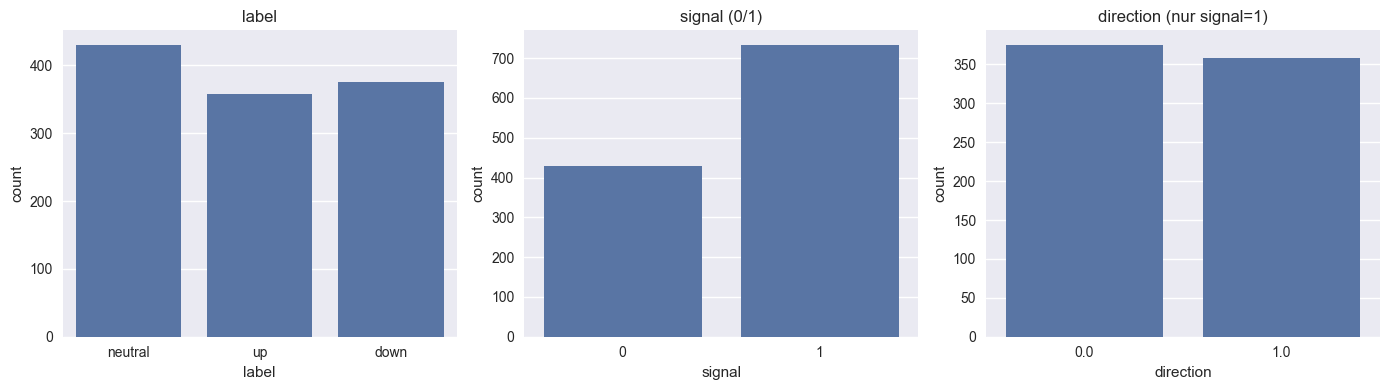

In [253]:
print("Label-Verteilung (neutral/up/down):")
print(df["label"].value_counts())

print("\nSignal-Verteilung (0=neutral, 1=move):")
print(df["signal"].value_counts())

print("\nDirection (0=down, 1=up, ohne NaN):")
print(df["direction"].value_counts(dropna=True))

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

sns.countplot(x="label", data=df, ax=axes[0])
axes[0].set_title("label")

sns.countplot(x="signal", data=df, ax=axes[1])
axes[1].set_title("signal (0/1)")

sns.countplot(x="direction", data=df[df["signal"] == 1], ax=axes[2])
axes[2].set_title("direction (nur signal=1)")

plt.tight_layout()
plt.show()


## 3. Zeitliche Train/Val/Test‑Splits

Um Data Leakage zu vermeiden, werden die Daten **chronologisch** aufgeteilt:

- **Test-Split**: alle Daten ab dem 1. Januar 2025.
- **Train+Validation**: alle Daten von 2020 bis Ende 2024, darin nochmal 80 % Train / 20 % Val.

So sieht das Modell den Testzeitraum beim Training nicht und wir erhalten eine realistische Out‑of‑Sample‑Bewertung.


In [254]:
# Parameter für den zeitlichen Split (werden auch in die JSON-Config geschrieben)
test_start = "2025-01-01"
train_frac_pretest = 0.8  # 80 % Train, 20 % Val vor test_start

# Test ab 2025-01-01, 80/20-Split innerhalb 2020–2024
splits = split_train_val_test(
    df,
    pd.to_datetime(test_start),
    train_frac_within_pretest=train_frac_pretest,
)

for name, split_df in splits.items():
    print(f"{name}: {split_df['date'].min().date()} → {split_df['date'].max().date()} (n={len(split_df)})")


train: 2020-04-14 → 2024-04-09 (n=756)
val: 2024-04-10 → 2024-12-31 (n=189)
test: 2025-01-02 → 2025-11-05 (n=218)


## 4. Stufe 1 – Signal‑Modell (neutral vs move)

In dieser Stufe trainiere ich ein Binary‑XGBoost‑Modell auf:

- Ziel: `signal` (0 = neutral, 1 = Bewegung up/down)
- Features: News‑Sentiment + Volatilität + Schatten + Kalender (`FEATURE_COLS`)

Wegen der starken Klassenungleichverteilung verwende ich `scale_pos_weight ≈ N_neg / N_pos`
und Early Stopping auf dem Validierungs‑Split.


In [255]:
# # Zielvariablen
# y_train_signal = build_signal_targets(splits["train"])
# y_val_signal = build_signal_targets(splits["val"])
# y_test_signal = build_signal_targets(splits["test"])

# X_train_signal = splits["train"][FEATURE_COLS]
# X_val_signal = splits["val"][FEATURE_COLS]
# X_test_signal = splits["test"][FEATURE_COLS]

# # model_signal = train_xgb_binary(
# # X_train_signal, y_train_signal,
# # X_val_signal, y_val_signal
# # )

# # model_signal

# import xgboost as xgb

# # Signal-Modell: etwas stärker regularisiert, gleich gewichtet (scale_pos_weight=1.0)
# model_signal = xgb.XGBClassifier(
#     objective="binary:logistic",
#     eval_metric="logloss",
#     max_depth=2,          # statt 3: flacherer Baum
#     learning_rate=0.05,
#     n_estimators=400,
#     subsample=0.8,        # leichter herunter
#     colsample_bytree=0.8,
#     min_child_weight=5,   # verhindert zu kleine Blätter
#     gamma=1.0,            # Bestrafung für weitere Splits
#     scale_pos_weight=1.0, # Move vs. Neutral gleich gewichten
#     random_state=42,
# )

# model_signal.fit(
#     X_train_signal,
#     y_train_signal,
#     eval_set=[(X_val_signal, y_val_signal)],
#     early_stopping_rounds=50,
#     verbose=False,
# )



In [256]:
# # Zielvariablen für das Signal-Modell
# y_train_signal = build_signal_targets(splits["train"])
# y_val_signal   = build_signal_targets(splits["val"])
# y_test_signal  = build_signal_targets(splits["test"])

# X_train_signal = splits["train"][FEATURE_COLS]
# X_val_signal   = splits["val"][FEATURE_COLS]
# X_test_signal  = splits["test"][FEATURE_COLS]

# import xgboost as xgb
# import numpy as np

# # Klassenverhältnis für scale_pos_weight (wie im ursprünglichen train_xgb_binary)
# n_pos = int((y_train_signal == 1).sum())
# n_neg = int((y_train_signal == 0).sum())
# scale_pos_weight = n_neg / max(n_pos, 1)

# print("n_neg:", n_neg, "n_pos:", n_pos, "scale_pos_weight:", scale_pos_weight)

# # Signal-Modell mit höherer Komplexität: tiefere Bäume, mehr Bäume
# model_signal = xgb.XGBClassifier(
#     objective="binary:logistic",
#     eval_metric="logloss",
#     max_depth=4,          # höher als vorher (3)
#     learning_rate=0.05,
#     n_estimators=600,     # mehr Bäume als vorher (400)
#     subsample=0.9,
#     colsample_bytree=0.9,
#     scale_pos_weight=scale_pos_weight,
#     random_state=42,
# )

# model_signal.fit(
#     X_train_signal,
#     y_train_signal,
#     eval_set=[(X_val_signal, y_val_signal)],
#     early_stopping_rounds=50,  # stoppt, wenn Val-Logloss nicht besser wird
#     verbose=False,
# )

# model_signal


In [257]:
# # ------------------ Signal-Training mit "klaren" Beispielen ------------------ #

# # Original-Splits
# df_train = splits["train"].copy()
# df_val   = splits["val"].copy()
# df_test  = splits["test"].copy()

# # 1) Zielvariablen wie bisher
# y_val_signal  = build_signal_targets(df_val)
# y_test_signal = build_signal_targets(df_test)

# # 2) Trainingsdaten filtern: nur klare Moves und klare Neutrals
# strong_move_thr = 0.0075  # 0.75 %
# clear_neutral_thr = 0.001 # 0.10 %

# abs_ret = df_train["lookahead_return"].abs()

# mask_strong_move = (df_train["signal"] == 1) & (abs_ret >= strong_move_thr)
# mask_clear_neutral = (df_train["signal"] == 0) & (abs_ret <= clear_neutral_thr)

# df_train_easy = df_train[mask_strong_move | mask_clear_neutral].copy()

# print("Train gesamt:", len(df_train), 
#       "| train_easy:", len(df_train_easy),
#       "| Moves:", int((df_train_easy["signal"] == 1).sum()),
#       "| Neutrals:", int((df_train_easy["signal"] == 0).sum()))

# # 3) X und y für das Signal-Modell
# X_train_signal = df_train_easy[FEATURE_COLS]
# y_train_signal = df_train_easy["signal"].astype(int).to_numpy()

# X_val_signal  = df_val[FEATURE_COLS]
# X_test_signal = df_test[FEATURE_COLS]

# # 4) Signal-Modell wie in deiner "guten" Version (v4/v5)
# import xgboost as xgb
# import numpy as np

# n_pos = int((y_train_signal == 1).sum())
# n_neg = int((y_train_signal == 0).sum())
# scale_pos_weight = n_neg / max(n_pos, 1)
# print("n_neg:", n_neg, "n_pos:", n_pos, "scale_pos_weight:", scale_pos_weight)

# model_signal = xgb.XGBClassifier(
#     objective="binary:logistic",
#     eval_metric="logloss",
#     max_depth=3,
#     learning_rate=0.05,
#     n_estimators=400,
#     subsample=0.9,
#     colsample_bytree=0.9,
#     scale_pos_weight=scale_pos_weight,
#     random_state=42,
# )

# model_signal.fit(
#     X_train_signal,
#     y_train_signal,
#     eval_set=[(X_val_signal, y_val_signal)],
#     early_stopping_rounds=50,
#     verbose=False,
# )

# model_signal


In [258]:
# Zielvariablen für das Signal-Modell (ohne Filter)
y_train_signal = build_signal_targets(splits["train"])
y_val_signal   = build_signal_targets(splits["val"])
y_test_signal  = build_signal_targets(splits["test"])

X_train_signal = splits["train"][feature_cols]
X_val_signal   = splits["val"][feature_cols]
X_test_signal  = splits["test"][feature_cols]

# train_xgb_binary ist oben schon importiert – der folgende Import ist optional
# from src.models.train_xgboost_two_stage import train_xgb_binary

# Signal-Modell mit den ursprünglichen Defaults aus train_xgboost_two_stage.py
model_signal = train_xgb_binary(
    X_train_signal,
    y_train_signal,
    X_val_signal,
    y_val_signal,
)

model_signal


/Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project/.venv/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

## 5. Stufe 1 – Qualität des Signal‑Modells

Hier werte ich das Signal‑Modell für Train/Val/Test aus:

- Accuracy,
- Confusion‑Matrix,
- Classification‑Report (Precision, Recall, F1).

Besonders wichtig sind Precision und Recall der Klasse `1` (move).



=== TRAIN (SIGNAL) ===
Accuracy gesamt: 0.635
move-Klasse: precision=0.684, recall=0.752, f1=0.717, support=464

Vollständiger Classification-Report (neutral & move):
              precision    recall  f1-score   support

     neutral      0.533     0.449     0.487       292
        move      0.684     0.752     0.717       464

    accuracy                          0.635       756
   macro avg      0.608     0.600     0.602       756
weighted avg      0.626     0.635     0.628       756



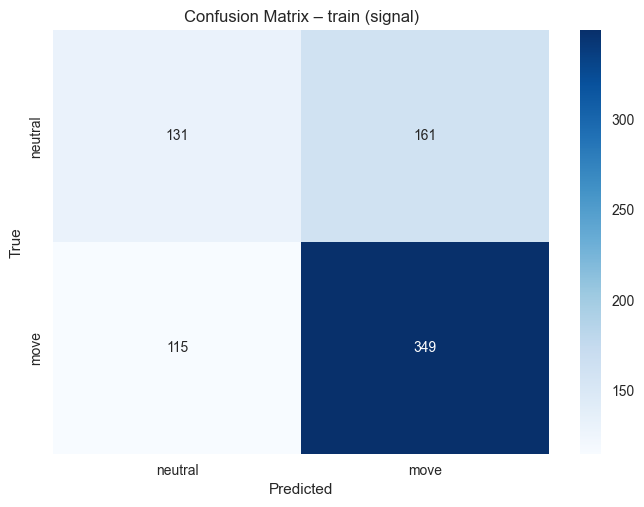


=== VAL (SIGNAL) ===
Accuracy gesamt: 0.603
move-Klasse: precision=0.657, recall=0.773, f1=0.710, support=119

Vollständiger Classification-Report (neutral & move):
              precision    recall  f1-score   support

     neutral      0.449     0.314     0.370        70
        move      0.657     0.773     0.710       119

    accuracy                          0.603       189
   macro avg      0.553     0.544     0.540       189
weighted avg      0.580     0.603     0.584       189



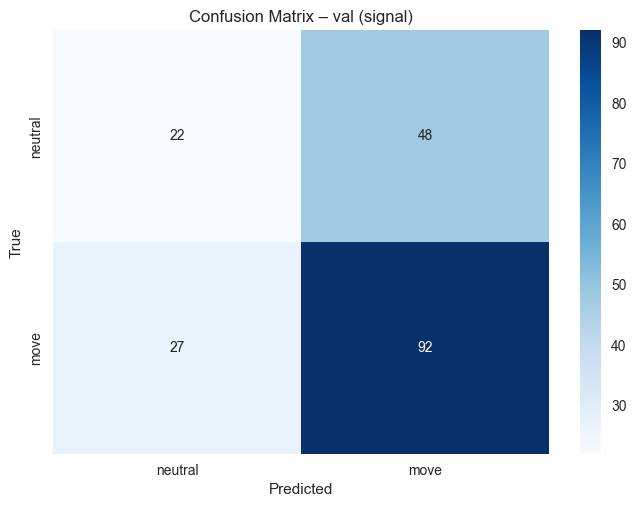


=== TEST (SIGNAL) ===
Accuracy gesamt: 0.624
move-Klasse: precision=0.736, recall=0.707, f1=0.721, support=150

Vollständiger Classification-Report (neutral & move):
              precision    recall  f1-score   support

     neutral      0.405     0.441     0.423        68
        move      0.736     0.707     0.721       150

    accuracy                          0.624       218
   macro avg      0.571     0.574     0.572       218
weighted avg      0.633     0.624     0.628       218



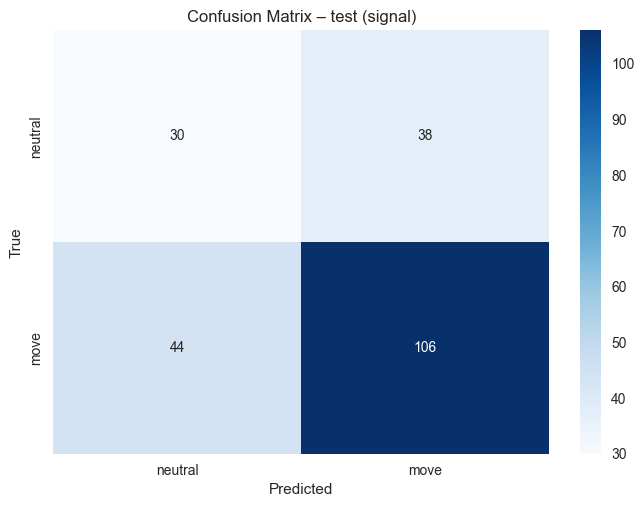

In [259]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def eval_and_plot_signal(name, model, X, y_true):
    """Evaluiert das Signal-Modell (0=neutral, 1=move) und hebt die move-Klasse hervor."""
    if len(X) == 0:
        print(f"[warn] {name} ist leer.")
        return

    # Wahrscheinlichkeiten und harte Vorhersage für Klasse 1 (move)
    y_prob = model.predict_proba(X)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)
    report = classification_report(
        y_true,
        y_pred,
        target_names=["neutral", "move"],
        output_dict=True,
        digits=3,
    )

    print(f"\n=== {name.upper()} (SIGNAL) ===")
    print(f"Accuracy gesamt: {acc:.3f}")

    move_stats = report["move"]
    print(
        f"move-Klasse: precision={move_stats['precision']:.3f}, "
        f"recall={move_stats['recall']:.3f}, "
        f"f1={move_stats['f1-score']:.3f}, "
        f"support={int(move_stats['support'])}"
    )

    print("\nVollständiger Classification-Report (neutral & move):")
    print(classification_report(
        y_true,
        y_pred,
        target_names=["neutral", "move"],
        digits=3,
    ))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["neutral", "move"],
        yticklabels=["neutral", "move"],
    )
    plt.title(f"Confusion Matrix – {name} (signal)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


def eval_and_plot_direction(name, model, X, y_true):
    """Evaluiert das Richtungs-Modell (0=down, 1=up) und hebt die up-Klasse hervor."""
    if len(X) == 0:
        print(f"[warn] {name} ist leer.")
        return

    y_prob = model.predict_proba(X)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)
    report = classification_report(
        y_true,
        y_pred,
        target_names=["down", "up"],
        output_dict=True,
        digits=3,
    )

    print(f"\n=== {name.upper()} (DIRECTION) ===")
    print(f"Accuracy gesamt: {acc:.3f}")

    up_stats = report["up"]
    print(
        f"up-Klasse: precision={up_stats['precision']:.3f}, "
        f"recall={up_stats['recall']:.3f}, "
        f"f1={up_stats['f1-score']:.3f}, "
        f"support={int(up_stats['support'])}"
    )

    print("\nVollständiger Classification-Report (down & up):")
    print(classification_report(
        y_true,
        y_pred,
        target_names=["down", "up"],
        digits=3,
    ))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Reds",
        xticklabels=["down", "up"],
        yticklabels=["down", "up"],
    )
    plt.title(f"Confusion Matrix – {name} (direction)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


# Aufrufe für beide Modelle:

eval_and_plot_signal("train", model_signal, X_train_signal, y_train_signal)
eval_and_plot_signal("val",   model_signal, X_val_signal,   y_val_signal)
eval_and_plot_signal("test",  model_signal, X_test_signal,  y_test_signal)



In [260]:
from sklearn.metrics import precision_score, recall_score

# --- Threshold-Test für das Signal-Modell (VAL) ---

# Wahrscheinlichkeiten P(signal=1) für den Val-Split
p_signal_val = model_signal.predict_proba(X_val_signal)[:, 1]

print("Signal-Thresholds auf VAL:")
for T_sig in [0.5, 0.6, 0.7]:
    y_pred_sig = (p_signal_val >= T_sig).astype(int)  # 1=move, 0=neutral
    prec = precision_score(y_val_signal, y_pred_sig, zero_division=0)
    rec = recall_score(y_val_signal, y_pred_sig, zero_division=0)
    print(f"T_signal={T_sig:.2f}  ->  precision_move={prec:.3f}, recall_move={rec:.3f}")


Signal-Thresholds auf VAL:
T_signal=0.50  ->  precision_move=0.657, recall_move=0.773
T_signal=0.60  ->  precision_move=0.000, recall_move=0.000
T_signal=0.70  ->  precision_move=0.000, recall_move=0.000


# X,y für Richtung (nur signal==1)
X_train_dir, y_train_dir = build_direction_targets(splits["train"])
X_val_dir, y_val_dir = build_direction_targets(splits["val"])
X_test_dir, y_test_dir = build_direction_targets(splits["test"])

# Hier bewusst kein Class-Weighting (scale_pos_weight=1.0)
model_dir = train_xgb_binary(
    X_train_dir, y_train_dir,
    X_val_dir, y_val_dir,
    scale_pos_weight=1.0
)

model_dir



=== TRAIN (DIRECTION) ===
Accuracy gesamt: 0.873
up-Klasse: precision=0.867, recall=0.854, f1=0.861, support=213

Vollständiger Classification-Report (down & up):
              precision    recall  f1-score   support

        down      0.878     0.888     0.883       251
          up      0.867     0.854     0.861       213

    accuracy                          0.873       464
   macro avg      0.872     0.871     0.872       464
weighted avg      0.873     0.873     0.873       464



/Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project/.venv/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


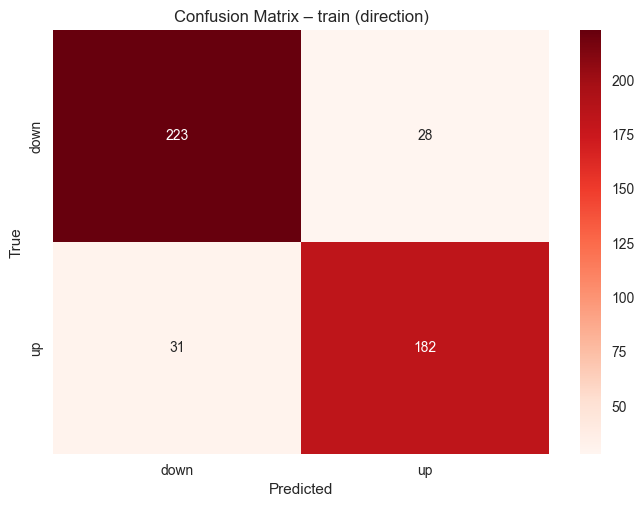


=== VAL (DIRECTION) ===
Accuracy gesamt: 0.689
up-Klasse: precision=0.706, recall=0.621, f1=0.661, support=58

Vollständiger Classification-Report (down & up):
              precision    recall  f1-score   support

        down      0.676     0.754     0.713        61
          up      0.706     0.621     0.661        58

    accuracy                          0.689       119
   macro avg      0.691     0.687     0.687       119
weighted avg      0.691     0.689     0.688       119



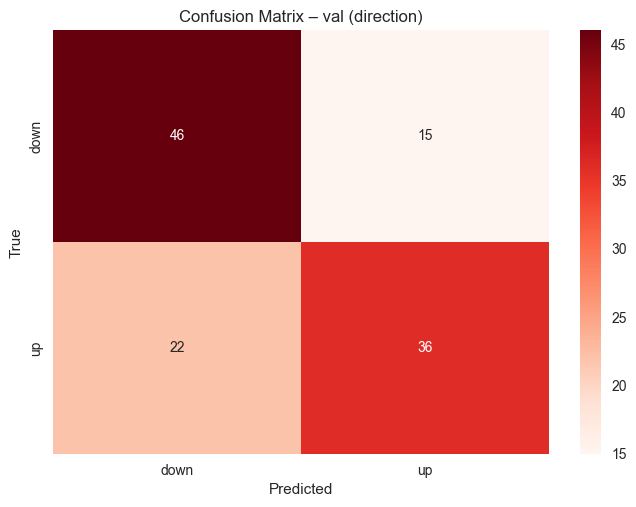


=== TEST (DIRECTION) ===
Accuracy gesamt: 0.727
up-Klasse: precision=0.803, recall=0.701, f1=0.748, support=87

Vollständiger Classification-Report (down & up):
              precision    recall  f1-score   support

        down      0.649     0.762     0.701        63
          up      0.803     0.701     0.748        87

    accuracy                          0.727       150
   macro avg      0.726     0.732     0.725       150
weighted avg      0.738     0.727     0.728       150



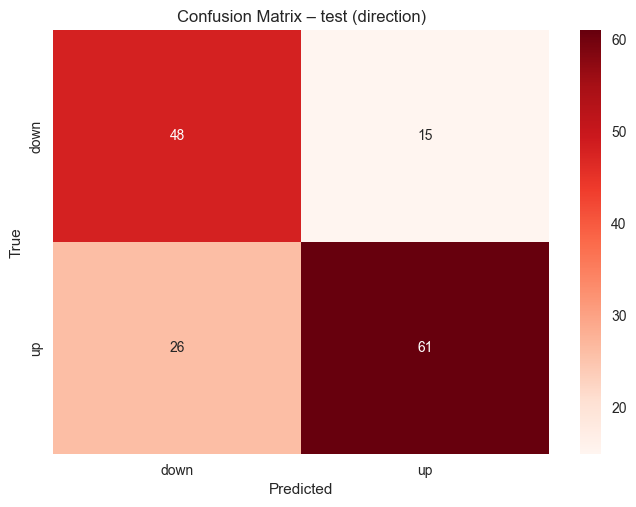

In [261]:
# X,y für Richtung (nur signal==1)
X_train_dir, y_train_dir = build_direction_targets(splits["train"], feature_cols=feature_cols)
X_val_dir,   y_val_dir   = build_direction_targets(splits["val"],   feature_cols=feature_cols)
X_test_dir,  y_test_dir  = build_direction_targets(splits["test"],  feature_cols=feature_cols)

# Kein Class-Weighting nötig, Klassen relativ ausgeglichen → scale_pos_weight=1.0
model_dir = train_xgb_binary(
    X_train_dir, y_train_dir,
    X_val_dir, y_val_dir,
    scale_pos_weight=1.0
)

eval_and_plot_direction("train", model_dir, X_train_dir, y_train_dir)
eval_and_plot_direction("val",   model_dir, X_val_dir,   y_val_dir)
eval_and_plot_direction("test",  model_dir, X_test_dir,  y_test_dir)


In [262]:
# --- Threshold-Test für das Richtungs-Modell (VAL, nur Move-Tage) ---

from sklearn.metrics import precision_score, recall_score

# Wahrscheinlichkeiten P(up=1) für den Val-Split (nur Move-Tage)
p_up_val = model_dir.predict_proba(X_val_dir)[:, 1]

print("Up-Thresholds auf VAL (nur Move-Tage):")
for T_up in [0.5, 0.6, 0.7]:
    y_pred_up = (p_up_val >= T_up).astype(int)  # 1=up, 0=down
    prec_up = precision_score(y_val_dir, y_pred_up, zero_division=0)
    rec_up = recall_score(y_val_dir, y_pred_up, zero_division=0)
    print(f"T_up={T_up:.2f}  ->  precision_up={prec_up:.3f}, recall_up={rec_up:.3f}")


Up-Thresholds auf VAL (nur Move-Tage):
T_up=0.50  ->  precision_up=0.706, recall_up=0.621
T_up=0.60  ->  precision_up=0.833, recall_up=0.431
T_up=0.70  ->  precision_up=0.933, recall_up=0.241


## 8. Feature‑Importance

Um besser zu verstehen, welche Merkmale die Modelle tatsächlich nutzen, schaue ich mir
die Feature‑Importances der beiden XGBoost‑Modelle an:

- **Signal‑Modell** (neutral vs move): Welche Kombination aus News‑Sentiment, Volatilität,
  Schatten und Kalender ist wichtig, um Tage mit Bewegungen von neutralen Tagen zu unterscheiden?
- **Richtungs‑Modell** (up vs down): Welche Features helfen dabei, die Richtung einer Bewegung
  vorherzusagen, sobald ein Signal erkannt wurde?

Die Balkendiagramme sortieren die Features nach absteigender Wichtigkeit, basierend auf
den vom Modell gelernten Splits.


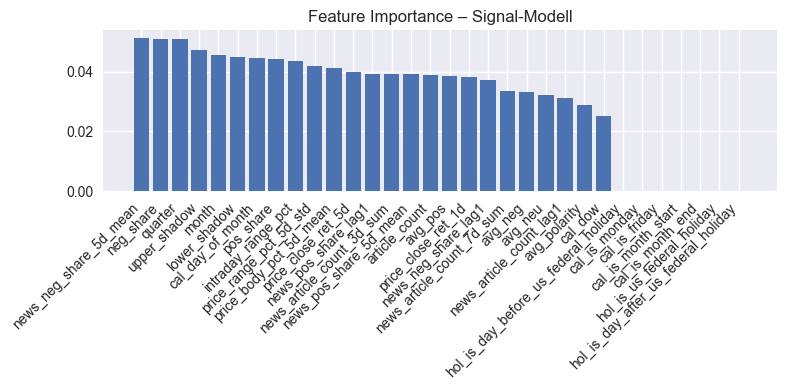

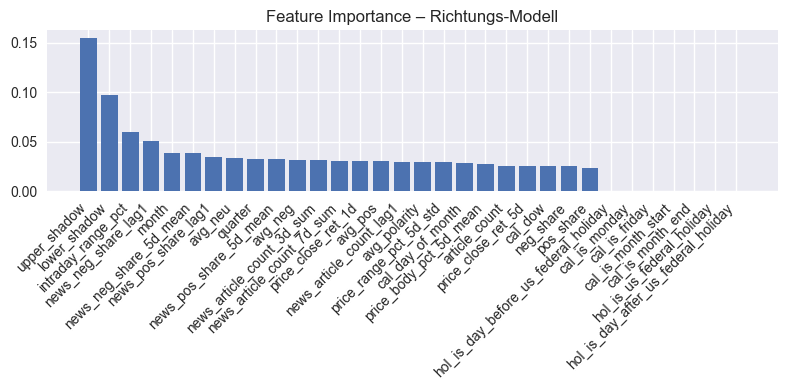

In [263]:
import numpy as np

def plot_feature_importance(model, title):
    importance = model.feature_importances_
    order = np.argsort(importance)[::-1]
    plt.figure(figsize=(8,4))
    plt.bar(range(len(order)), importance[order])
    plt.xticks(range(len(order)),
               [feature_cols[i] for i in order],
               rotation=45, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_feature_importance(model_signal, "Feature Importance – Signal-Modell")
plot_feature_importance(model_dir, "Feature Importance – Richtungs-Modell")


## 9. Kombinierte 3‑Klassen‑Auswertung (neutral / up / down)

Zum Schluss kombiniere ich beide Stufen zu einem finalen 3‑Klassen‑Output:

1. Das Signal‑Modell entscheidet für jeden Test‑Tag:
   - `signal = 0` → endgültiges Label = `neutral`
   - `signal = 1` → es liegt eine Bewegung vor (`move`)
2. Nur wenn `signal = 1`, wird das Richtungs‑Modell aufgerufen:
   - `direction = 1` → endgültiges Label = `up`
   - `direction = 0` → endgültiges Label = `down`

Aus diesen beiden Modellen baue ich ein kombiniertes Label (`neutral`/`up`/`down`) und
vergleiche es mit der wahren `label`‑Spalte im Testzeitraum ab 2025. Die 3‑Klassen‑Confusion‑Matrix
und der Classification‑Report zeigen, wie gut das Gesamtsystem neutrale Tage von Bewegungen
und die Richtung der Bewegungen unterscheidet.


3-Klassen-Confusion-Matrix (rows=true, cols=pred):


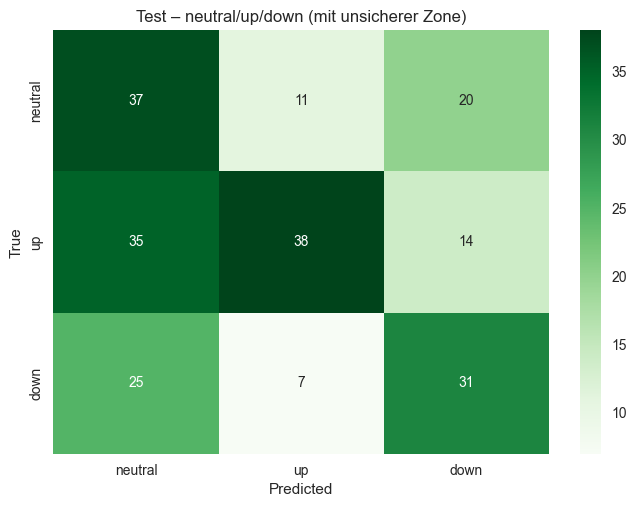


3-Klassen-Report:
              precision    recall  f1-score   support

     neutral      0.381     0.544     0.448        68
          up      0.679     0.437     0.531        87
        down      0.477     0.492     0.484        63

    accuracy                          0.486       218
   macro avg      0.512     0.491     0.488       218
weighted avg      0.528     0.486     0.492       218



In [264]:
from sklearn.metrics import classification_report, confusion_matrix

X_test_all = splits["test"][feature_cols]

# 1) Schwellen festlegen
T_signal   = 0.5   # Signal-Schwelle lassen
T_up_high  = 0.65   # sicher up
T_up_low   = 0.35   # sicher down

# 2) Wahrscheinlichkeiten berechnen
p_signal_test = model_signal.predict_proba(X_test_all)[:, 1]  # P(move)
p_up_test     = model_dir.predict_proba(X_test_all)[:, 1]     # P(up | move)

# 3) Harte Entscheidung für signal (0=neutral, 1=move)
signal_pred = (p_signal_test >= T_signal).astype(int)

# 4) Kombiniertes 3-Klassen-Label mit „unsicherer Zone“ für Richtung
#    - signal=0              -> neutral
#    - signal=1 & p_up>=high -> up
#    - signal=1 & p_up<=low  -> down
#    - signal=1 & zwischen   -> neutral (unsicher, nicht handeln)
combined_pred = []
for sig, p_up in zip(signal_pred, p_up_test):
    if sig == 0:
        combined_pred.append("neutral")
    else:
        if p_up >= T_up_high:
            combined_pred.append("up")
        elif p_up <= T_up_low:
            combined_pred.append("down")
        else:
            combined_pred.append("neutral")
combined_pred = np.array(combined_pred)

combined_true = splits["test"]["label"].to_numpy()

# 5) Auswertung wie bisher
print("3-Klassen-Confusion-Matrix (rows=true, cols=pred):")
cm3 = confusion_matrix(combined_true, combined_pred, labels=["neutral", "up", "down"])
sns.heatmap(
    cm3,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["neutral", "up", "down"],
    yticklabels=["neutral", "up", "down"],
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test – neutral/up/down (mit unsicherer Zone)")
plt.show()

print("\n3-Klassen-Report:")
print(classification_report(combined_true, combined_pred, labels=["neutral", "up", "down"], digits=3))


In [265]:
# Verteilung der Up-Wahrscheinlichkeiten auf dem Test-Split
print("min/max p_up_test:", p_up_test.min(), p_up_test.max())

in_band_low  = ((p_up_test > 0.35) & (p_up_test < 0.4)).sum()
in_band_high = ((p_up_test > 0.6)  & (p_up_test < 0.65)).sum()
print("Anzahl p_up in (0.35, 0.40):", in_band_low)
print("Anzahl p_up in (0.60, 0.65):", in_band_high)


min/max p_up_test: 0.07354836 0.883398
Anzahl p_up in (0.35, 0.40): 5
Anzahl p_up in (0.60, 0.65): 12


In [266]:
in_band = ((p_up_test > 0.35) & (p_up_test < 0.4)) | ((p_up_test > 0.6) & (p_up_test < 0.65))
print("davon mit signal_pred=0:", int(((in_band) & (signal_pred == 0)).sum()))
print("davon mit signal_pred=1:", int(((in_band) & (signal_pred == 1)).sum()))


davon mit signal_pred=0: 7
davon mit signal_pred=1: 10


In [267]:
import numpy as np

# Wir setzen voraus:
# - combined_true, combined_pred aus der kombinierten Test-Zelle
# - signal_pred (0/1) aus derselben Zelle
# - true "down" = Label "down"

down_mask = combined_true == "down"
n_down = int(down_mask.sum())

# Wie viele echte down-Tage werden vom Signal-Modell als neutral/move eingestuft?
n_down_signal0 = int(((signal_pred == 0) & down_mask).sum())  # als neutral abgestempelt
n_down_signal1 = int(((signal_pred == 1) & down_mask).sum())  # vom Signal-Modell erkannt

# Unter den vom Signal-Modell erkannten down-Tagen:
n_down_correct_dir = int(((signal_pred == 1) & (combined_pred == "down") & down_mask).sum())
n_down_wrong_up   = int(((signal_pred == 1) & (combined_pred == "up")   & down_mask).sum())

print(f"Anzahl echter down-Tage im Test: {n_down}")
print(f"- davon vom Signal-Modell als neutral (signal=0): {n_down_signal0}")
print(f"- davon vom Signal-Modell als move  (signal=1): {n_down_signal1}")
print(f"    - davon korrekt als down erkannt: {n_down_correct_dir}")
print(f"    - davon fälschlich als up erkannt: {n_down_wrong_up}")


Anzahl echter down-Tage im Test: 63
- davon vom Signal-Modell als neutral (signal=0): 19
- davon vom Signal-Modell als move  (signal=1): 44
    - davon korrekt als down erkannt: 31
    - davon fälschlich als up erkannt: 7


## 10. Baseline-Ergebnisse speichern (v0)

Bevor ich weitere Experimente (z.B. andere Thresholds oder geänderte Label-Logik) durchführe,
möchte ich den aktuellen Stand des Zwei-Stufen-Modells festhalten.

In dieser Zelle speichere ich:

- die wichtigsten Hyperparameter / Einstellungen (Label-Logik, Features, Splits),
- die Metriken für das Signal-Modell (Train/Val/Test, Threshold = 0.5),
- die Metriken für das Richtungs-Modell (Train/Val/Test, Threshold = 0.5),
- die 3‑Klassen-Auswertung (`neutral` / `up` / `down`) auf dem Test-Split.

Alles wird als eine JSON-Datei unter `../results/two_stage_v0_h4_thr1pct_strict.json` abgelegt,
sodass ich die Baseline später leicht mit neuen Varianten vergleichen kann.


In [268]:
from pathlib import Path
import json
from sklearn.metrics import classification_report, confusion_matrix

# Ergebnisse im Notebook-Ordner speichern: notebooks/results
results_dir = project_root / "notebooks" / "results"
results_dir.mkdir(parents=True, exist_ok=True)

# Dateiname enthält die Experiment-ID
out_path = results_dir / f"two_stage__{EXP_ID}.json"


def binary_metrics_dict(y_true, y_prob, threshold, target_names):
    """
    Hilfsfunktion, die für ein binäres Modell die wichtigsten Metriken
    in ein Dictionary schreibt.

    Parameter:
    - y_true: true Labels (0/1)
    - y_prob: vorhergesagte Wahrscheinlichkeit für Klasse 1 (shape: [n_samples])
    - threshold: Entscheidungsgrenze, ab der wir 1 vorhersagen
    - target_names: Namen der beiden Klassen, z.B. ["neutral", "move"]

    Rückgabe:
    - dict mit threshold, classification_report (als dict) und confusion_matrix (als Liste)
    """
    # Binäre Vorhersage aus den Wahrscheinlichkeiten ableiten
    y_pred = (y_prob >= threshold).astype(int)

    # Classification-Report in ein dict konvertieren (für JSON geeignet)
    report = classification_report(
        y_true,
        y_pred,
        target_names=target_names,
        output_dict=True,
        digits=3,
    )

    # Confusion-Matrix als normale Python-Liste speichern
    cm = confusion_matrix(y_true, y_pred).tolist()

    return {
        "threshold": float(threshold),
        "report": report,
        "confusion_matrix": cm,
    }


# ---------------- Signal-Modell: Metriken für alle Splits ---------------- #

# Wahrscheinlichkeiten für Klasse 1 (move) je Split
probs_train_signal = model_signal.predict_proba(X_train_signal)[:, 1]
probs_val_signal = model_signal.predict_proba(X_val_signal)[:, 1]
probs_test_signal = model_signal.predict_proba(X_test_signal)[:, 1]

signal_metrics = {
    "train": binary_metrics_dict(
        y_true=y_train_signal,
        y_prob=probs_train_signal,
        threshold=0.5,
        target_names=["neutral", "move"],
    ),
    "val": binary_metrics_dict(
        y_true=y_val_signal,
        y_prob=probs_val_signal,
        threshold=0.5,
        target_names=["neutral", "move"],
    ),
    "test": binary_metrics_dict(
        y_true=y_test_signal,
        y_prob=probs_test_signal,
        threshold=0.5,
        target_names=["neutral", "move"],
    ),
}


# ---------------- Richtungs-Modell: Metriken für alle Splits ------------- #

# Wahrscheinlichkeiten für Klasse 1 (up) je Split
probs_train_dir = model_dir.predict_proba(X_train_dir)[:, 1]
probs_val_dir = model_dir.predict_proba(X_val_dir)[:, 1]
probs_test_dir = model_dir.predict_proba(X_test_dir)[:, 1]

direction_metrics = {
    "train": binary_metrics_dict(
        y_true=y_train_dir,
        y_prob=probs_train_dir,
        threshold=0.5,
        target_names=["down", "up"],
    ),
    "val": binary_metrics_dict(
        y_true=y_val_dir,
        y_prob=probs_val_dir,
        threshold=0.5,
        target_names=["down", "up"],
    ),
    "test": binary_metrics_dict(
        y_true=y_test_dir,
        y_prob=probs_test_dir,
        threshold=0.5,
        target_names=["down", "up"],
    ),
}


# ---------------- Kombinierte 3-Klassen-Auswertung auf Test -------------- #

# Für die kombinierte Auswertung verwenden wir alle Test-Tage (auch neutral)
X_test_all = splits["test"][feature_cols]

# Schritt 1: Signal-Vorhersage (0=neutral, 1=move)
signal_prob_test = model_signal.predict_proba(X_test_all)[:, 1]
signal_pred_test = (signal_prob_test >= 0.5).astype(int)

# Schritt 2: Richtungs-Vorhersage (nur relevant, wenn signal_pred_test == 1)
dir_prob_test = model_dir.predict_proba(X_test_all)[:, 1]
dir_pred_test = (dir_prob_test >= 0.5).astype(int)

# Endgültiges Label kombinieren:
# - wenn signal=0 → "neutral"
# - wenn signal=1 und direction=1 → "up"
# - wenn signal=1 und direction=0 → "down"
combined_pred = np.where(
    signal_pred_test == 0,
    "neutral",
    np.where(dir_pred_test == 1, "up", "down"),
)
combined_true = splits["test"]["label"].to_numpy()

combined_report = classification_report(
    combined_true,
    combined_pred,
    labels=["neutral", "up", "down"],
    output_dict=True,
    digits=3,
)
combined_cm = confusion_matrix(
    combined_true,
    combined_pred,
    labels=["neutral", "up", "down"],
).tolist()


# ---------------- Alles zusammen als JSON speichern --------------------- #

# Annahme: du hast oben im Notebook Variablen definiert:
# test_start = "2025-01-01"
# train_frac_pretest = 0.8

# Parameter Gradient Boost
signal_params = model_signal.get_xgb_params()
direction_params = model_dir.get_xgb_params()
signal_params["feature_importances_"] = model_signal.feature_importances_.tolist()
direction_params["feature_importances_"] = model_dir.feature_importances_.tolist()


results = {
    "config": {
        "exp_id": exp_config["exp_id"],
        "horizon_days": exp_config["label_params"]["horizon_days"],
        "up_threshold": exp_config["label_params"]["up_threshold"],
        "down_threshold": exp_config["label_params"]["down_threshold"],
        "strict_monotonic": exp_config["label_params"]["strict_monotonic"],
        "dataset_path": str(dataset_path),
        "feature_cols": feature_cols,
        "test_start": test_start,
        "train_frac_within_pretest": train_frac_pretest,
    },
    "model_params": {
        "signal": signal_params,      # alle XGBoost-Settings für Stufe 1
        "direction": direction_params # alle XGBoost-Settings für Stufe 2
    },
    "signal": signal_metrics,
    "direction": direction_metrics,
    "combined_test": {
        "report": combined_report,
        "confusion_matrix": combined_cm,
        "labels": ["neutral", "up", "down"],
    },
}



with open(out_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"Baseline-Ergebnisse gespeichert unter: {out_path}")


Baseline-Ergebnisse gespeichert unter: /Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project/notebooks/results/two_stage__v10_h4_thr0p3pct_tol0p3_30dfeat.json


## 11. Zusammenfassung der wichtigsten Kennzahlen

Zum Abschluss fasse ich die Ergebnisse aller Teilmodelle in tabellarischer Form zusammen:

- **Signal-Modell** (`signal`):
  - Fokus auf der Klasse `move` (Bewegung) für Train/Val/Test.
- **Richtungs-Modell** (`direction`):
  - Fokus auf der Klasse `up` für Train/Val/Test.
- **Kombinierte 3-Klassen-Auswertung** (`combined_test`):
  - Precision/Recall/F1 für `neutral`, `up`, `down` auf dem Test-Split.

Die Tabellen kann ich leicht kopieren oder als CSV/JSON speichern und z. B. in Notebook 3
oder in der schriftlichen Dokumentation verwenden.


In [269]:
import pandas as pd

# ---------------- Signal-Modell: move-Klasse pro Split ---------------- #

rows = []
for split in ["train", "val", "test"]:
    rep = signal_metrics[split]["report"]
    move_stats = rep["move"]  # positive Klasse
    rows.append({
        "model": "signal",
        "split": split,
        "class": "move",
        "precision": move_stats["precision"],
        "recall": move_stats["recall"],
        "f1": move_stats["f1-score"],
        "support": move_stats["support"],
    })

signal_summary = pd.DataFrame(rows)


# ---------------- Richtungs-Modell: up-Klasse pro Split ---------------- #

rows = []
for split in ["train", "val", "test"]:
    rep = direction_metrics[split]["report"]
    up_stats = rep["up"]  # positive Klasse
    rows.append({
        "model": "direction",
        "split": split,
        "class": "up",
        "precision": up_stats["precision"],
        "recall": up_stats["recall"],
        "f1": up_stats["f1-score"],
        "support": up_stats["support"],
    })

direction_summary = pd.DataFrame(rows)


# -------- Kombinierte 3-Klassen-Auswertung auf dem Test-Split ---------- #

rows = []
for cls in ["neutral", "up", "down"]:
    stats = combined_report[cls]
    rows.append({
        "model": "combined_test",
        "split": "test",
        "class": cls,
        "precision": stats["precision"],
        "recall": stats["recall"],
        "f1": stats["f1-score"],
        "support": stats["support"],
    })

combined_summary = pd.DataFrame(rows)


# ----------------- Alles gemeinsam anzeigen ---------------------------- #

print("Signal-Modell (move-Klasse, pro Split):")
display(signal_summary)

print("\nRichtungs-Modell (up-Klasse, pro Split):")
display(direction_summary)

print("\nKombinierte 3-Klassen-Auswertung (Test-Split, neutral/up/down):")
display(combined_summary)

# Optional: alles in einem DataFrame zusammenführen (z.B. zum Export)
all_summary = pd.concat([signal_summary, direction_summary, combined_summary],
                        ignore_index=True)


Signal-Modell (move-Klasse, pro Split):


,model,split,class,precision,recall,f1,support
0,signal,train,move,0.684314,0.752155,0.716632,464.0
1,signal,val,move,0.657143,0.773109,0.710425,119.0
2,signal,test,move,0.736111,0.706667,0.721088,150.0



Richtungs-Modell (up-Klasse, pro Split):


,model,split,class,precision,recall,f1,support
0,direction,train,up,0.866667,0.854460,0.860520,213.0
1,direction,val,up,0.705882,0.620690,0.660550,58.0
2,direction,test,up,0.802632,0.701149,0.748466,87.0



Kombinierte 3-Klassen-Auswertung (Test-Split, neutral/up/down):


,model,split,class,precision,recall,f1,support
0,combined_test,test,neutral,0.405405,0.441176,0.422535,68.0
1,combined_test,test,up,0.602941,0.471264,0.529032,87.0
2,combined_test,test,down,0.434211,0.523810,0.474820,63.0


In [270]:
metrics_path = results_dir / f"two_stage__{EXP_ID}_metrics.csv"
all_summary.to_csv(metrics_path, index=False)
print("Tabellarische Zusammenfassung gespeichert unter:", metrics_path)

Tabellarische Zusammenfassung gespeichert unter: /Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project/notebooks/results/two_stage__v10_h4_thr0p3pct_tol0p3_30dfeat_metrics.csv


## Threshold-Tuning für Signal- und Richtungsmodell

Bisher verwenden wir feste Schwellen von 0.5 für beide Modelle:

- Signal: `p(signal=1) >= 0.5` → move
- Richtung: `p(up=1) >= 0.5` → up, sonst down

Um die **Precision** zu erhöhen (weniger Fehlinvestitionen), testen wir auf dem
**Validation-Split** verschiedene Kombinationen von Thresholds:

- `T_signal` in [0.5, 0.9] – wie sicher muss das Modell sein, dass ein Move stattfindet?
- `T_up`     in [0.5, 0.9] – wie sicher muss das Richtungsmodell für „up“ sein?

Für jede Kombination berechnen wir auf dem Val-Split die 3‑Klassen‑Metriken
(neutral/up/down) und wählen später eine Kombination mit:

- möglichst hoher Precision (up/down),
- akzeptablem Recall/F1.

Anschließend werten wir die gewählte Kombination auf dem Test-Split aus.


In [271]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

# ----------------------------------------------------------
# 1) Wahrscheinlichkeiten für den Validation-Split vorbereiten
# ----------------------------------------------------------
# Features des Val-Splits (für ALLE Tage, nicht gefiltert)
X_val_all = splits["val"][feature_cols]

# Echte 3-Klassen-Labels im Val-Split: "neutral", "up", "down"
y_val_label = splits["val"]["label"].to_numpy()

# Signal-Modell: P(signal=1) für jeden Val-Tag
p_signal_val = model_signal.predict_proba(X_val_all)[:, 1]

# Richtungs-Modell: P(up=1) für jeden Val-Tag
# (Down = implizit 1 - P(up), aber wir brauchen nur P(up))
p_up_val = model_dir.predict_proba(X_val_all)[:, 1]

# Reihenfolge der Klassen für Metriken und Confusion Matrix
LABELS = ["neutral", "up", "down"]


def eval_thresholds_on_val(T_signal_grid, T_up_grid):
    """Evaluiert verschiedene Kombinationen von Thresholds auf dem Val-Split.

    Parameter
    ---------
    T_signal_grid : iterable
        Kandidatenwerte für den Signal-Threshold (P(signal=1) >= T_signal).
    T_up_grid : iterable
        Kandidatenwerte für den Up-Threshold (P(up=1) >= T_up).

    Rückgabe
    --------
    pd.DataFrame
        Eine Zeile pro Threshold-Kombination mit diversen Metriken:
        - macro_precision / macro_recall / macro_f1
        - precision/recall/f1 pro Klasse (neutral/up/down)
    """
    rows = []

    for T_sig in T_signal_grid:
        for T_up in T_up_grid:
            # -----------------------------
            # 1) Binäre Entscheidungen
            # -----------------------------
            # Signal-Entscheidung: move (1) oder neutral (0)
            signal_pred = (p_signal_val >= T_sig).astype(int)

            # Richtungs-Entscheidung: up (1) oder down (0)
            # (gilt nur, wenn signal_pred == 1, aber wir berechnen es für alle)
            up_pred_bin = (p_up_val >= T_up).astype(int)

            # -----------------------------
            # 2) Kombiniertes 3-Klassen-Label
            # -----------------------------
            # Wenn Signal-Modell sagt "kein Move" -> neutral
            # Wenn Move -> Richtung entscheidet zwischen up und down
            y_pred_label = np.where(
                signal_pred == 0,
                "neutral",
                np.where(up_pred_bin == 1, "up", "down"),
            )

            # -----------------------------
            # 3) Metriken pro Klasse
            # -----------------------------
            prec, rec, f1, support = precision_recall_fscore_support(
                y_val_label,
                y_pred_label,
                labels=LABELS,
                zero_division=0,  # falls eine Klasse nie vorhergesagt wird
            )

            # Macro-Averages (einfacher Überblick)
            metrics = dict(
                T_signal=T_sig,
                T_up=T_up,
                macro_precision=prec.mean(),
                macro_recall=rec.mean(),
                macro_f1=f1.mean(),
            )

            # Einzelmetriken pro Klasse hinzufügen
            for i, cls in enumerate(LABELS):
                metrics[f"precision_{cls}"] = prec[i]
                metrics[f"recall_{cls}"] = rec[i]
                metrics[f"f1_{cls}"] = f1[i]
                metrics[f"support_{cls}"] = support[i]

            rows.append(metrics)

    return pd.DataFrame(rows)


# Kandidaten-Thresholds für Signal und Up
T_signal_grid = np.arange(0.5, 0.91, 0.05)  # 0.50, 0.55, ..., 0.90
T_up_grid = np.arange(0.5, 0.91, 0.05)

# Alle Kombinationen auswerten
val_results = eval_thresholds_on_val(T_signal_grid, T_up_grid)

# Nach z.B. hoher macro_precision und macro_f1 sortieren
val_results_sorted = val_results.sort_values(
    ["macro_precision", "macro_f1"], ascending=False
)

# Die Top-Kombinationen anzeigen (hier kannst du dir eine aussuchen)
val_results_sorted.head(10)


,T_signal,T_up,macro_precision,macro_recall,macro_f1,precision_neutral,recall_neutral,f1_neutral,support_neutral,precision_up,recall_up,f1_up,support_up,precision_down,recall_down,f1_down,support_down
1,0.50,0.55,0.472235,0.460142,0.442462,0.44898,0.314286,0.369748,70,0.540541,0.344828,0.421053,58,0.427184,0.721311,0.536585,61
7,0.50,0.85,0.470648,0.389763,0.321662,0.44898,0.314286,0.369748,70,0.600000,0.051724,0.095238,58,0.362963,0.803279,0.500000,61
3,0.50,0.65,0.463215,0.447799,0.420362,0.44898,0.314286,0.369748,70,0.517241,0.258621,0.344828,58,0.423423,0.770492,0.546512,61
0,0.50,0.50,0.459126,0.461555,0.449488,0.44898,0.314286,0.369748,70,0.490196,0.431034,0.458716,58,0.438202,0.639344,0.520000,61
2,0.50,0.60,0.455215,0.442618,0.419283,0.44898,0.314286,0.369748,70,0.500000,0.275862,0.355556,58,0.416667,0.737705,0.532544,61
4,0.50,0.70,0.421617,0.418781,0.377020,0.44898,0.314286,0.369748,70,0.409091,0.155172,0.225000,58,0.406780,0.786885,0.536313,61
5,0.50,0.75,0.419104,0.418498,0.372104,0.44898,0.314286,0.369748,70,0.400000,0.137931,0.205128,58,0.408333,0.803279,0.541436,61
6,0.50,0.80,0.416153,0.401257,0.343708,0.44898,0.314286,0.369748,70,0.416667,0.086207,0.142857,58,0.382812,0.803279,0.518519,61
8,0.50,0.90,0.266327,0.372521,0.285770,0.44898,0.314286,0.369748,70,0.000000,0.000000,0.000000,58,0.350000,0.803279,0.487562,61
9,0.55,0.50,0.123457,0.333333,0.180180,0.37037,1.000000,0.540541,70,0.000000,0.000000,0.000000,58,0.000000,0.000000,0.000000,61


In [272]:
from sklearn.metrics import classification_report, confusion_matrix

# ----------------------------------------------------------
# 1) Gewählte Thresholds (aus Val-Analyse übernehmen)
# ----------------------------------------------------------
T_signal_best = 0.70  # <--- hier deinen Wert aus val_results_sorted eintragen
T_up_best = 0.70      # <--- hier deinen Wert aus val_results_sorted eintragen

# ----------------------------------------------------------
# 2) Wahrscheinlichkeiten auf dem Test-Split berechnen
# ----------------------------------------------------------
X_test_all = splits["test"][feature_cols]
y_test_label = splits["test"]["label"].to_numpy()

p_signal_test = model_signal.predict_proba(X_test_all)[:, 1]
p_up_test = model_dir.predict_proba(X_test_all)[:, 1]

# Binäre Entscheidungen mit den gewählten Thresholds
signal_pred_test = (p_signal_test >= T_signal_best).astype(int)
up_pred_test = (p_up_test >= T_up_best).astype(int)

# Kombiniertes 3-Klassen-Label wie zuvor:
# - signal=0 -> neutral
# - signal=1 & up=1 -> up
# - signal=1 & up=0 -> down
y_pred_test = np.where(
    signal_pred_test == 0,
    "neutral",
    np.where(up_pred_test == 1, "up", "down"),
)

# ----------------------------------------------------------
# 3) Auswertung auf dem Test-Split
# ----------------------------------------------------------
print("Confusion Matrix (Test, labels=neutral/up/down):")
print(confusion_matrix(y_test_label, y_pred_test, labels=LABELS))

print("\nClassification Report (Test):")
print(classification_report(y_test_label, y_pred_test, labels=LABELS, digits=3))


Confusion Matrix (Test, labels=neutral/up/down):
[[68  0  0]
 [87  0  0]
 [63  0  0]]

Classification Report (Test):
              precision    recall  f1-score   support

     neutral      0.312     1.000     0.476        68
          up      0.000     0.000     0.000        87
        down      0.000     0.000     0.000        63

    accuracy                          0.312       218
   macro avg      0.104     0.333     0.159       218
weighted avg      0.097     0.312     0.148       218



/Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels w

## Direktes 3‑Klassen‑XGBoost (neutral / up / down)

Hier trainiere ich ein zusätzliches Referenzmodell, das die drei Klassen
direkt vorhersagt (`label` ∈ {neutral, up, down}), um das Zwei‑Stufen‑Setup
mit einem einfachen 3‑Klassen‑Modell zu vergleichen.


In [273]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

# Mapping von Label-Strings auf numerische Klassen
label_to_int = {"neutral": 0, "up": 1, "down": 2}
int_to_label = {v: k for k, v in label_to_int.items()}

def encode_labels(series):
    return series.map(label_to_int).to_numpy()

# X und y für alle Splits
X_train_3 = splits["train"][FEATURE_COLS]
X_val_3   = splits["val"][FEATURE_COLS]
X_test_3  = splits["test"][FEATURE_COLS]

y_train_3 = encode_labels(splits["train"]["label"])
y_val_3   = encode_labels(splits["val"]["label"])
y_test_3  = encode_labels(splits["test"]["label"])


NameError: name 'FEATURE_COLS' is not defined

In [ ]:
# Direktes 3-Klassen-XGBoost
model_3class = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    max_depth=3,
    learning_rate=0.05,
    n_estimators=400,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
)

model_3class.fit(
    X_train_3,
    y_train_3,
    eval_set=[(X_val_3, y_val_3)],
    early_stopping_rounds=50,
    verbose=False,
)

model_3class


/Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project/.venv/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)


=== TRAIN (3-Klassen) ===
Confusion Matrix (rows=true, cols=pred):


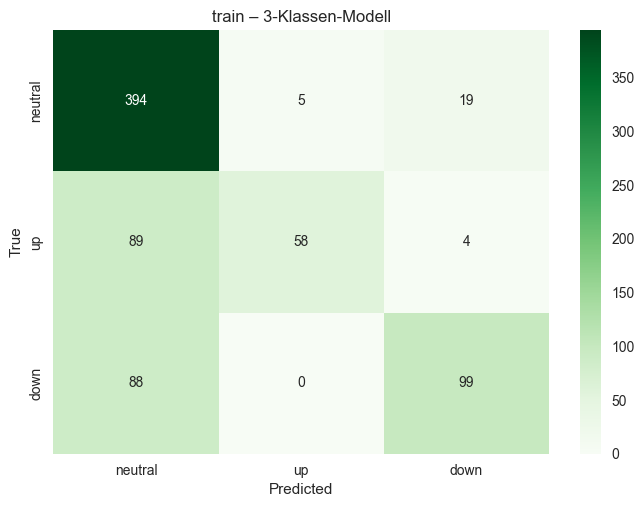

Classification Report:
              precision    recall  f1-score   support

     neutral      0.690     0.943     0.797       418
          up      0.921     0.384     0.542       151
        down      0.811     0.529     0.641       187

    accuracy                          0.729       756
   macro avg      0.807     0.619     0.660       756
weighted avg      0.766     0.729     0.707       756


=== VAL (3-Klassen) ===
Confusion Matrix (rows=true, cols=pred):


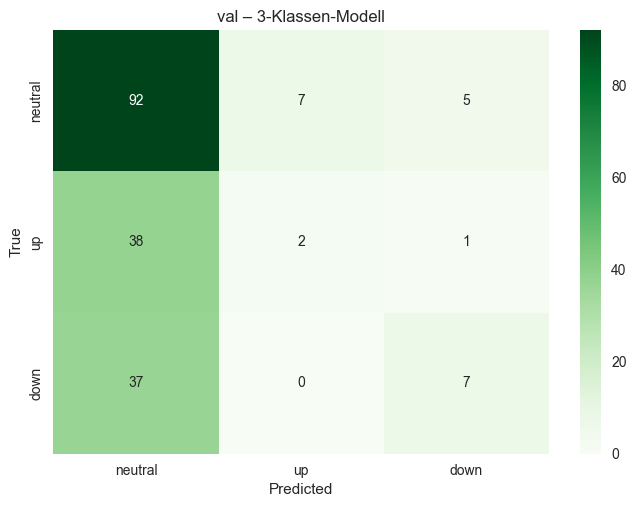

Classification Report:
              precision    recall  f1-score   support

     neutral      0.551     0.885     0.679       104
          up      0.222     0.049     0.080        41
        down      0.538     0.159     0.246        44

    accuracy                          0.534       189
   macro avg      0.437     0.364     0.335       189
weighted avg      0.477     0.534     0.448       189


=== TEST (3-Klassen) ===
Confusion Matrix (rows=true, cols=pred):


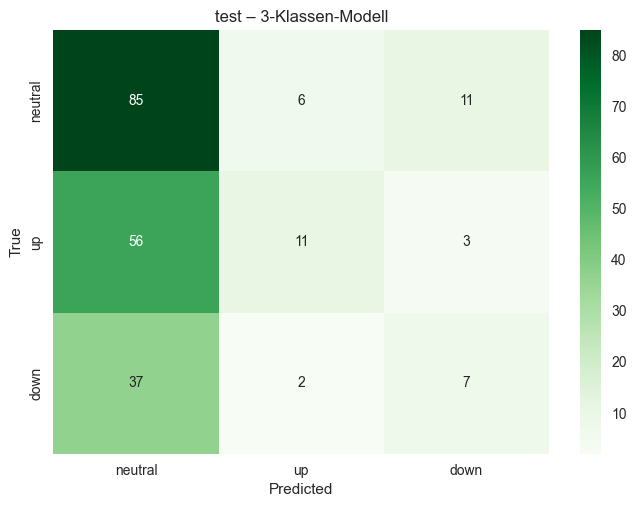

Classification Report:
              precision    recall  f1-score   support

     neutral      0.478     0.833     0.607       102
          up      0.579     0.157     0.247        70
        down      0.333     0.152     0.209        46

    accuracy                          0.472       218
   macro avg      0.463     0.381     0.354       218
weighted avg      0.480     0.472     0.408       218



In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def eval_3class_split(name, model, X, y_true_int):
    if len(X) == 0:
        print(f"[warn] Split {name} leer.")
        return

    y_pred_int = model.predict(X)
    y_true = np.vectorize(int_to_label.get)(y_true_int)
    y_pred = np.vectorize(int_to_label.get)(y_pred_int)

    print(f"\n=== {name.upper()} (3-Klassen) ===")
    print("Confusion Matrix (rows=true, cols=pred):")
    cm = confusion_matrix(y_true, y_pred, labels=["neutral", "up", "down"])
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Greens",
        xticklabels=["neutral", "up", "down"],
        yticklabels=["neutral", "up", "down"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{name} – 3-Klassen-Modell")
    plt.show()

    print("Classification Report:")
    print(classification_report(y_true, y_pred, labels=["neutral", "up", "down"], digits=3))

eval_3class_split("train", model_3class, X_train_3, y_train_3)
eval_3class_split("val",   model_3class, X_val_3,   y_val_3)
eval_3class_split("test",  model_3class, X_test_3,  y_test_3)
